# Food Image Classification with EfficientNetB0
This project focuses on classifying food images into 11 categories using a fine-tuned EfficientNetB0 model. The model is trained using augmented image data to improve generalization and accuracy. It employs mixed precision training for better performance and efficiency. The training process is optimized using callbacks such as ModelCheckpoint, EarlyStopping, and ReduceLROnPlateau. Additionally, class imbalance is addressed by calculating class weights to ensure fair training. The model's performance is evaluated using metrics like accuracy, precision, and recall on the validation dataset, providing a robust food image classification solution.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

# You can20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can als write up to o write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/food11-image-dataset/validation/Fried food/208.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/45.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/56.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/89.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/20.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/275.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/212.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/239.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/58.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/150.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/6.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/109.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/149.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/187.jpg
/kaggle/input/food11-image-dataset/validation/Fried food/76.jpg
/kaggle/input/food11-image-datase

**1. Preprocessing the Dataset**

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Corrected directories (no trailing commas)
train_dir = "/kaggle/input/food11-image-dataset/training"
val_dir = "/kaggle/input/food11-image-dataset/validation"
test_dir = "/kaggle/input/food11-image-dataset/evaluation"

# Data Augmentation for Training Set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Add validation split
)

# Train Generator (with data augmentation)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training'  # Use the training subset
)

# Validation Generator (without augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Test Generator (without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 7896 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


**2. Build the Model**

In [3]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

def build_fine_tuned_model(input_shape=(224, 224, 3), num_classes=11, unfreeze_layers=50):
    # Load EfficientNetB0 with pre-trained ImageNet weights
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers
    for layer in base_model.layers[:]:
        layer.trainable = True 

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.7)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.7)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Compile the model
    model = Model(inputs=base_model.input, outputs=outputs)
    optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', Precision(), Recall()])
    return model

# Build the model
model = build_fine_tuned_model()
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 5,896,878 (22.49 MB)

 Trainable params: 5,852,295 (22.32 MB)

 Non-trainable params: 44,583 (174.16 KB)

**3. Callbacks**

In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Model Checkpoint
mcp = ModelCheckpoint("/kaggle/working/best_model_20241203-044642.keras", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Reduce Learning Rate on Plateau
lrd = ReduceLROnPlateau(monitor="val_accuracy", factor=0.2, patience=3, verbose=1, mode="max", min_lr=1e-6)

# Early Stopping
es = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1)

# Callbacks list
callbacks = [mcp, lrd, es]


**4. Mixed Precision Training**

In [5]:
from tensorflow.keras.mixed_precision import Policy, set_global_policy
import tensorflow as tf
# Set mixed precision policy
policy = Policy('mixed_float16')
set_global_policy(policy)

# Confirm the policy
print(f"Mixed precision policy: {tf.keras.mixed_precision.global_policy()}")


Mixed precision policy: <FloatDTypePolicy "mixed_float16">


**5. Train the Model**

In [6]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))


# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[mcp, lrd, es],
    class_weight=class_weights_dict
)


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733745558.320011     119 service.cc:145] XLA service 0x7b1bb8001f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733745558.320091     119 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733745558.320096     119 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733745625.667579     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1363 - loss: 4.2062 - precision: 0.1436 - recall: 0.0876
Epoch 1: val_accuracy improved from -inf to 0.06764, saving model to /kaggle/working/best_model_20241203-044642.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.1366 - loss: 4.2012 - precision: 0.1440 - recall: 0.0878 - val_accuracy: 0.0676 - val_loss: 2.4921 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.3178 - loss: 2.3542 - precision: 0.4027 - recall: 0.2298
Epoch 2: val_accuracy did not improve from 0.06764
124/124 ━━━━━━━━━━━━━━━━━━━━ 116s 892ms/step - accuracy: 0.3182 - loss: 2.3520 - precision: 0.4032 - recall: 0.2302 - val_accuracy: 0.0676 - val_loss: 2.8317 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.5227 - loss: 1.4359 - precision: 0.6369 - recall: 0.

In [7]:

# Evaluate the model on the validation or test data
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(validation_generator)

# Print the results
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")


108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.9076 - loss: 0.4212 - precision: 0.9186 - recall: 0.8950
Validation Loss: 0.41835057735443115
Validation Accuracy: 0.903207004070282
Validation Precision: 0.9164914488792419
Validation Recall: 0.8895043730735779


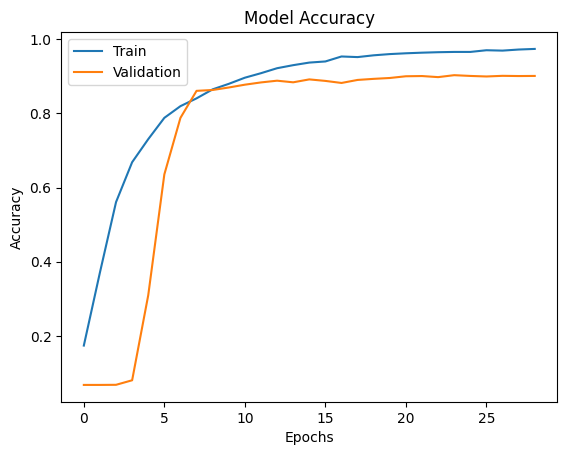

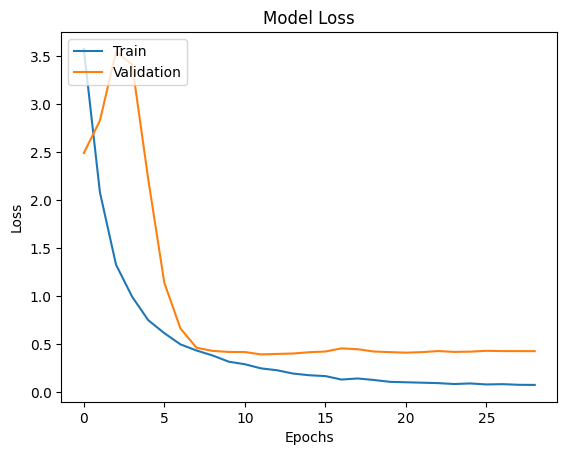

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
